In [1]:
import pandas as pd
import numpy as np
from hierarchicalcausalmodels.models.HSCM.HSCM import HSCM # type: ignore
import matplotlib.pyplot as plt
from scipy.stats import norm, expon


/tmp/ipykernel_1637/860456903.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


ImportError: cannot import name 'kl_div' from 'scipy.stats' (/usr/local/lib/python3.10/dist-packages/scipy/stats/__init__.py)

a


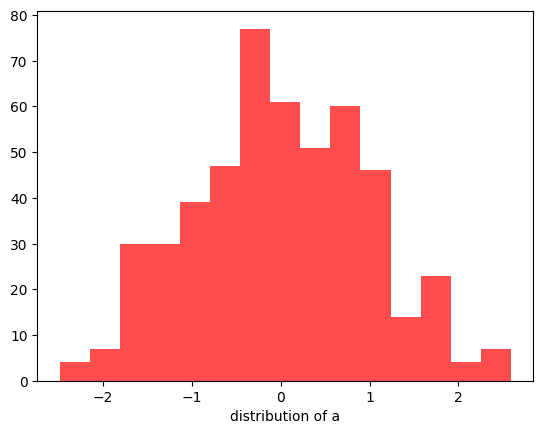

c


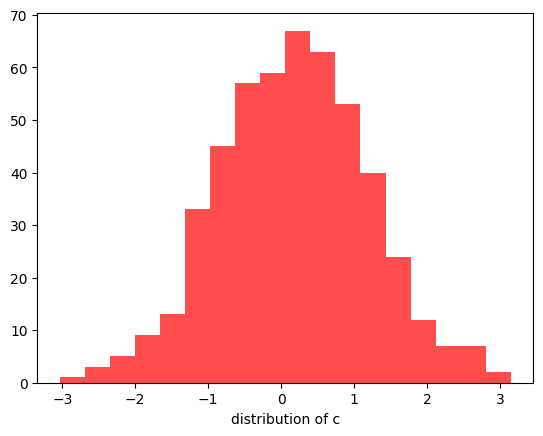

e


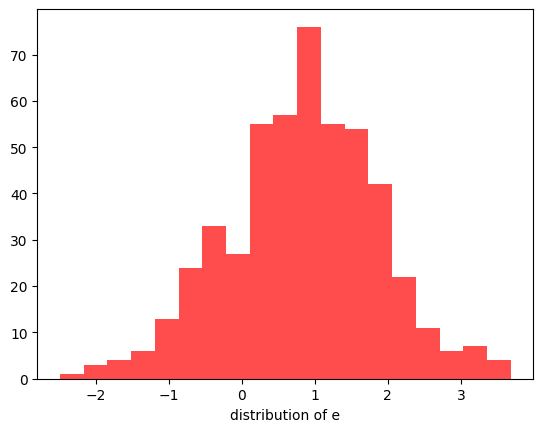

a


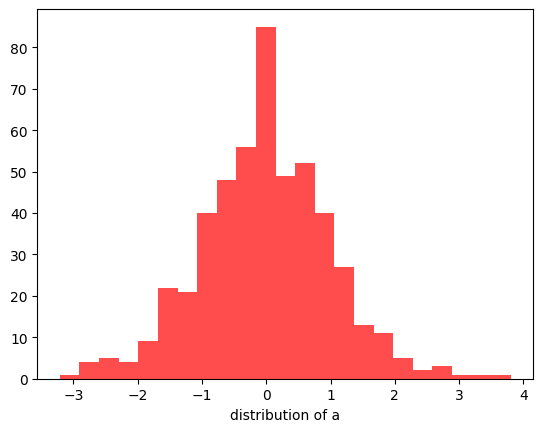

c


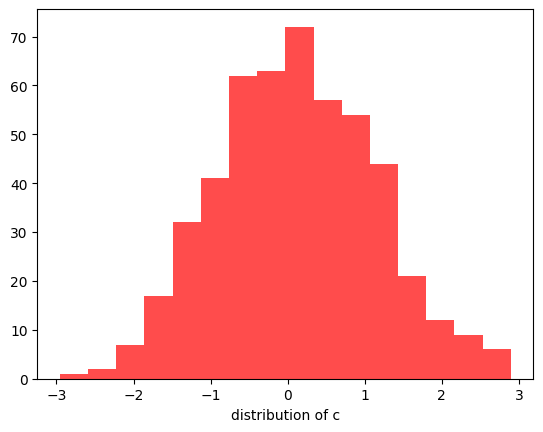

e


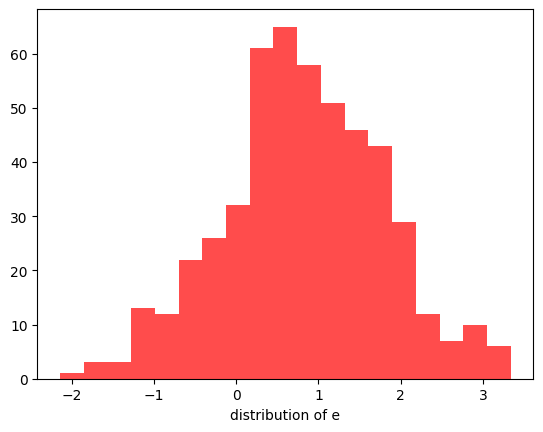

Sampled data has been stored in sampled_data.txt


In [15]:




# Define the HSCM model structure
nodes = ["a", "b", "c", "d", "e"]
edges = [("a", "b"), ('a', 'c'), ("b", "c"), ("c", "d"), ("b", "d"), ("d", "e"), ("b", "e")]
unit_nodes = ["a", "c", "e"]
subunit_nodes = ["d", "b"]
sizes = [150] * 500  # You can adjust this based on your data

# Initialize the HSCM model
hscm = HSCM(nodes, edges, unit_nodes, subunit_nodes, sizes, node_functions={}, data=None)

# Define random functions for each node
random_functions = {
    "a": lambda x: norm.ppf(x, 0, 1),
    "b": lambda x: expon.ppf(x, 0, 1),
    "c": lambda x: norm.ppf(x, 0, 1),
    "d": lambda x: norm.ppf(x, 0, 1),
    "e": lambda x: norm.ppf(x, 0, 1)
}

# Define additive functions for each node
additive_functions = {
    "a": {},
    "b": {"a": lambda a: a * 0.1},
    "c": {"a": lambda a: a * 0.1, "b": lambda b: np.mean(np.array(list(b))) * 0.1},
    "d": {"b": lambda b: b * 3, "c": lambda c: c * 2},
    "e": {"d": lambda d: np.mean(np.array(list(d))) * 0.1, "b": lambda b: np.mean(np.sin(np.array(list(b))))}
}


In [ ]:

# Set up the HSCM model
hscm.additive_model(additive_functions, random_functions)

# Sample data from the model
sampled_data = hscm.sample_data()

# Plot the sampled data
hscm.plot_data()

# Set distributions from the loaded data
hscm.set_distribution_from_data()

# Perform additional analysis or modify the model as needed
# For example, you can change the graph structure or random functions here

# Re-sample data after modifications
new_sampled_data = hscm.sample_data()

# Plot the new sampled data
hscm.plot_data()

# Compare the original and new sampled data
'''
for node in nodes:
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.hist([sampled_data[node + str(i)] for i in range(len(sizes))], bins='auto', alpha=0.7, color='b')
    plt.title(f"Original {node}")
    plt.subplot(1, 2, 2)
    plt.hist([new_sampled_data[node + str(i)] for i in range(len(sizes))], bins='auto', alpha=0.7, color='r')
    plt.title(f"Modified {node}")
    plt.show()
'''
# Perform any additional analysis or visualization as needed
# Store sampled data in a txt file
from experiments.utils.utils import store_dict_to_file, load_dict_from_file # type: ignore

# Define the filename
filename = 'sampled_data.txt'

# Store the sampled data
store_dict_to_file(new_sampled_data, filename)

print(f"Sampled data has been stored in {filename}")


In [16]:
# ... (previous code remains the same)

# Add these imports at the beginning of your notebook
from sklearn.decomposition import PCA # type: ignore
from sklearn.manifold import TSNE # type: ignore
from umap import UMAP # type: ignore
from sklearn.preprocessing import StandardScaler # type: ignore

# Function to create scatter plots
def plot_comparison(original, sampled, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(original[:, 0], original[:, 1], c='blue', alpha=0.5, label='Original')
    plt.scatter(sampled[:, 0], sampled[:, 1], c='red', alpha=0.5, label='Sampled')
    plt.title(title)
    plt.legend()
    plt.show()

# Load the sampled data from the text file
filename = 'sampled_data.txt'
sampled_data = load_dict_from_file(filename)

# Load the original data from the text file
original_filename = 'original_data.txt'
data = load_dict_from_file(original_filename)

# Print the first few items of both original and sampled data for comparison
print("First few items of original data:")
for i, (key, value) in enumerate(data.items()):
    print(f"{key}: {value}")
    if i == 4:  # Print only the first 5 items
        break

print("\nFirst few items of sampled data:")
for i, (key, value) in enumerate(sampled_data.items()):
    print(f"{key}: {value}")
    if i == 4:  # Print only the first 5 items
        break


# Prepare data for dimensionality reduction for unit nodes
original_data = np.column_stack([data[f"{node}{i}"] for node in unit_nodes for i in range(len(sizes))])
sampled_data = np.column_stack([sampled_data[f"{node}{i}"] for node in unit_nodes for i in range(len(sizes))])

# Prepare data for dimensionality reduction for subunit nodes
original_data_subunit = np.column_stack([data[f"{node}{i}"] for node in subunit_nodes for i in range(len(sizes))])
sampled_data_subunit = np.column_stack([sampled_data[f"{node}{i}"] for node in subunit_nodes for i in range(len(sizes))])





# Combine and scale the data
combined_data = np.vstack((original_data, sampled_data))
scaler = StandardScaler()
scaled_data = scaler.fit_transform(combined_data)

# Perform dimensionality reduction
# PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(scaled_data)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(scaled_data)

# UMAP
umap_reducer = UMAP(n_components=2, random_state=42)
umap_result = umap_reducer.fit_transform(scaled_data)

# Split results back into original and sampled
n_original = original_data.shape[0]
original_pca, sampled_pca = pca_result[:n_original], pca_result[n_original:]
original_tsne, sampled_tsne = tsne_result[:n_original], tsne_result[n_original:]
original_umap, sampled_umap = umap_result[:n_original], umap_result[n_original:]

# Plot comparisons
plot_comparison(original_pca, sampled_pca, "PCA: Original vs Sampled Data")
plot_comparison(original_tsne, sampled_tsne, "t-SNE: Original vs Sampled Data")
plot_comparison(original_umap, sampled_umap, "UMAP: Original vs Sampled Data")

# ... (rest of the previous code)

ImportError: cannot import name 'UMAP' from 'umap' (/usr/local/lib/python3.10/dist-packages/umap/__init__.py)

In [ ]:
# Add these imports at the beginning of your notebook
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import roc_curve, precision_recall_curve
from sklearn.preprocessing import StandardScaler

def evaluate_generated_data(original_data, generated_data):
    # Combine original and generated data
    X = np.vstack((original_data, generated_data))
    y = np.hstack((np.zeros(len(original_data)), np.ones(len(generated_data))))

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train a Random Forest classifier
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = clf.predict(X_test_scaled)
    y_pred_proba = clf.predict_proba(X_test_scaled)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")

    # Plot ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

    # Plot Precision-Recall curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label='Precision-Recall Curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.show()

# Evaluate the initial sampled data
print("Evaluating initial sampled data:")
evaluate_generated_data(original_data, sampled_data)

# After modifying the model and generating new_sampled_data
print("\nEvaluating new sampled data:")
evaluate_generated_data(original_data, new_sampled_data)

In [ ]:

distances = hscm.calculate_distribution_distances()

# Print or analyze the distances
for i, unit_distances in enumerate(distances):
    print(f"Unit {i}:")
    for metric, value in unit_distances.items():
        print(f"  {metric}: {value}")